# 1. Import Libraries

In [1]:
import numpy as np
import pandas as pd

from keras import models
from keras import layers

import matplotlib.pyplot as plt

import re
import os
from tqdm import tqdm_notebook as tqdm
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from nltk.corpus import wordnet
from nltk.stem import SnowballStemmer
from bs4 import BeautifulSoup
import string
import nltk
from sklearn.feature_extraction.text import CountVectorizer
import numpy as np
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split


from langdetect import detect

Using TensorFlow backend.


# 2. Import Data, Overview and Filters

In [2]:
data_reviews = pd.read_csv('steam_reviews.csv')

In [3]:
data_reviews

,date_posted,funny,helpful,hour_played,is_early_access_review,recommendation,review,title
0,2019-02-10,2,4,578,False,Recommended,&gt Played as German Reich&gt Declare war on B...,Expansion - Hearts of Iron IV: Man the Guns
1,2019-02-10,0,0,184,False,Recommended,yes.,Expansion - Hearts of Iron IV: Man the Guns
2,2019-02-07,0,0,892,False,Recommended,Very good game although a bit overpriced in my...,Expansion - Hearts of Iron IV: Man the Guns
3,2018-06-14,126,1086,676,False,Recommended,Out of all the reviews I wrote This one is pro...,Dead by Daylight
4,2017-06-20,85,2139,612,False,Recommended,Disclaimer I survivor main. I play games for f...,Dead by Daylight
...,...,...,...,...,...,...,...,...
434886,2018-11-17,1,37,10,False,Recommended,YOUR FLESH WILL ROT AND DECAY.STEEL IS IMMORTA...,"Warhammer 40,000: Mechanicus"
434887,2018-11-17,3,41,38,False,Recommended,Domini and Dominae I believe what we are deali...,"Warhammer 40,000: Mechanicus"
434888,2018-11-20,0,0,36,False,Recommended,First off if you like X Com style of games you...,"Warhammer 40,000: Mechanicus"
434889,2018-11-18,1,44,12,False,Recommended,As a disclaimer I'm an AdMech player on the ta...,"Warhammer 40,000: Mechanicus"


In [4]:
data_reviews.describe()

,funny,helpful,hour_played
count,4.348910e+05,434891.000000,434891.000000
mean,5.333024e+05,1.004114,364.130773
std,4.785640e+07,59.462935,545.961198
min,0.000000e+00,0.000000,0.000000
25%,0.000000e+00,0.000000,62.000000
50%,0.000000e+00,0.000000,190.000000
75%,0.000000e+00,0.000000,450.000000
max,4.294967e+09,28171.000000,31962.000000


In [5]:
data_reviews.isna().sum()

date_posted                  0
funny                        0
helpful                      0
hour_played                  0
is_early_access_review       0
recommendation               0
review                    1516
title                        0
dtype: int64

In [6]:
data_reviews.dropna(inplace = True)
data_reviews.reset_index(drop = True, inplace = True)

In [7]:
len(data_reviews)

433375

# 3. Preprocessing

In [8]:
def clean(text_list, lemmatize, stemmer, stop_word):
    """
    Function that a receives a list of strings and preprocesses it.
    
    :param text_list: List of strings.
    :param lemmatize: Tag to apply lemmatization if True.
    :param stemmer: Tag to apply the stemmer if True.
    """
    updates = []
    
    for j in tqdm(range(len(text_list))):
        
        text = text_list[j]
        
        #LOWERCASE TEXT
        text = text.lower()
        
        #REMOVE NUMERICAL DATA AND PUNCTUATION
        text = re.sub("[^a-zA-Z-zÀ-ÿ]", ' ', text)
        
        #REMOVE TAGS
        text = BeautifulSoup(text).get_text()
        
        if lemmatize:
            text = " ".join(lemma.lemmatize(word) for word in text.split())
        
        if stemmer:
            text = " ".join(snowball_stemmer.stem(word) for word in text.split())
            
        if stop_word:
            text = [w for w in text.split() if not w in stop]
            text = " ".join(text)
        
        updates.append(text)
        
    return updates

def update_df(dataframe, list_updated):
    dataframe.update(pd.DataFrame({"Text": list_updated}))

In [10]:
stop = set(stopwords.words('english'))
exclude = set(string.punctuation)
lemma = WordNetLemmatizer()

In [11]:
stop = {'a',
 'about',
 'above',
 'after',
 'again',
 'against',
 'ain',
 'all',
 'am',
 'an',
 'and',
 'any',
 'are',
 'aren',
 'as',
 'at',
 'be',
 'because',
 'been',
 'before',
 'being',
 'below',
 'between',
 'both',
 'but',
 'by',
 'can',
 'd',
 'did',
 'didn',
 'do',
 'does',
 'doing',
 'don',
 'down',
 'during',
 'each',
 'few',
 'for',
 'from',
 'further',
 'had',
 'has',
 'hasn',
 'have',
 'haven',
 'having',
 'he',
 'her',
 'here',
 'hers',
 'herself',
 'him',
 'himself',
 'his',
 'how',
 'i',
 'if',
 'in',
 'into',
 'is',
 'it',
 "it's",
 'its',
 'itself',
 'just',
 'll',
 'm',
 'ma',
 'me',
 'mightn',
 'more',
 'most',
 'mustn',
 'my',
 'myself',
 'no',
 'nor',
 'now',
 'o',
 'of',
 'off',
 'on',
 'once',
 'only',
 'or',
 'other', 'our', 'ours', 'ourselves', 'out', 'over', 'own', 're',
 's', 'same', 'shan', "shan't", 'she', "she's", 'should', "should've", 'so', 'some', 'such', 't', 'than',
 'that', "that'll", 'the', 'their', 'theirs', 'them', 'themselves', 'then', 'there', 'these', 'they', 'this', 'those', 'through',
 'to', 'too', 'under', 'until', 'up', 've', 'very', 'was', 'we', 'were', 'weren', 'what', 'when', 'where', 'which', 'while', 'who', 'whom',
 'why', 'will', 'with', 'won', 'y', 'you', "you'd", "you'll", "you're", "you've", 'your', 'yours', 'yourself', 'yourselves'}

In [12]:
clean_reviews = clean(data_reviews['review'], lemmatize = True, stemmer = False, stop_word = True)

C:\Users\gsmfa\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  # This is added back by InteractiveShellApp.init_path()


In [13]:
length_review = []
for i in range(0, len(data_reviews)):
    length_review.append(len(clean_reviews[i]))

In [14]:
data_reviews['length_review'] = length_review
data_reviews['clean_reviews'] = clean_reviews

In [15]:
data_reviews.groupby('length_review')['recommendation'].count().head(10)

length_review
0     8727
1      710
2     2964
3     7311
4    11986
5     3675
6     2645
7     5545
8     6595
9    15447
Name: recommendation, dtype: int64

In [16]:
data_reviews = data_reviews[data_reviews['length_review'] > 3].reset_index(drop = True)

In [17]:
#reviews_words = []
#for i in range (0, len(data_reviews)):
#    reviews_words.append(data_reviews['clean_reviews'][i].split())
#data_reviews['clean_reviews'] = reviews_words

In [18]:
data_reviews.head(10)

,date_posted,funny,helpful,hour_played,is_early_access_review,recommendation,review,title,length_review,clean_reviews
0,2019-02-10,2,4,578,False,Recommended,&gt Played as German Reich&gt Declare war on B...,Expansion - Hearts of Iron IV: Man the Guns,159,gt played german reich gt declare war belgium ...
1,2019-02-07,0,0,892,False,Recommended,Very good game although a bit overpriced in my...,Expansion - Hearts of Iron IV: Man the Guns,122,good game although bit overpriced opinion pref...
2,2018-06-14,126,1086,676,False,Recommended,Out of all the reviews I wrote This one is pro...,Dead by Daylight,1155,review wrote one probably serious one wrote st...
3,2017-06-20,85,2139,612,False,Recommended,Disclaimer I survivor main. I play games for f...,Dead by Daylight,803,disclaimer survivor main play game fun not com...
4,2016-12-12,4,55,2694,False,Recommended,ENGLISH After playing for more than two years ...,Dead by Daylight,3764,english playing two year given task reviewing ...
5,2017-09-17,12,228,48,False,Recommended,Out of all the reviews I wrote This one is pro...,Dead by Daylight,1155,review wrote one probably serious one wrote st...
6,2018-12-24,295,219,71,False,Recommended,I have never been told to kill myself more tha...,Dead by Daylight,28,never told kill playing game
7,2018-09-21,2,54,400,False,Recommended,Any longtime Dead by Daylight player knows tha...,Dead by Daylight,1133,longtime dead daylight player know isn horror ...
8,2018-12-05,380,271,414,False,Recommended,if you think cs go is toxic try this game,Dead by Daylight,25,think c go toxic try game
9,2018-12-04,11,106,900,False,Recommended,This is simultaneously the most fun and most i...,Dead by Daylight,1181,simultaneously fun infuriating game played lon...


In [19]:
language = []
for i in tqdm(range(0,len(data_reviews))):
    language.append(detect(data_reviews['clean_reviews'][i]))

C:\Users\gsmfa\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


In [20]:
data_reviews['language'] = language

In [21]:
data_reviews.to_csv('data_reviews.csv', index=False)

In [2]:
data_reviews = pd.read_csv('data_reviews.csv')

In [3]:
data_reviews.groupby('language')['recommendation'].count()

language
af      9571
ca      2860
cs       450
cy      5703
da     13863
de      1362
en    300204
es      3968
et      2446
fi      1273
fr      3248
hr      1963
hu       738
id      2232
it      4066
lt       680
lv       430
nl      4236
no      9009
pl      5619
pt      1736
ro      4154
sk       549
sl      3692
so     16137
sq      1394
sv      2439
sw      1886
tl      6243
tr      1265
vi       247
Name: recommendation, dtype: int64

In [4]:
data_reviewsEN = data_reviews[data_reviews['language'] == 'en']

In [82]:
Sample_data_reviewsEN = data_reviewsEN.sample(frac=0.7, random_state=1)

In [83]:
Sample_data_reviewsEN.groupby('recommendation')['language'].count()

recommendation
Not Recommended     71728
Recommended        138415
Name: language, dtype: int64

In [99]:
vectorizer = CountVectorizer(max_df = 0.9, min_df=0.003, max_features= 1900, binary= False, ngram_range=(1, 3))
X = vectorizer.fit_transform(Sample_data_reviewsEN['clean_reviews'])

In [100]:
reviews_vec = X.toarray()

In [101]:
Sample_data_reviewsEN.loc[Sample_data_reviewsEN['recommendation'] == 'Not Recommended', 'rec'] = 0
Sample_data_reviewsEN.loc[Sample_data_reviewsEN['recommendation'] == 'Recommended', 'rec'] = 1
y = Sample_data_reviewsEN['rec']

In [118]:
print(vectorizer.get_feature_names())

['aaa', 'ability', 'able', 'able play', 'absolute', 'absolutely', 'access', 'access game', 'account', 'across', 'act', 'action', 'active', 'activity', 'actual', 'actually', 'add', 'added', 'addicted', 'addicting', 'addicting game', 'addictive', 'addictive game', 'adding', 'adding new', 'addition', 'admit', 'adrenaline', 'advantage', 'adventure', 'advice', 'af', 'affect', 'afford', 'age', 'ago', 'agree', 'ahead', 'ai', 'aim', 'aiming', 'air', 'ak', 'alive', 'allow', 'allowed', 'allowing', 'allows', 'almost', 'almost every', 'almost hour', 'alone', 'along', 'alot', 'alot fun', 'alpha', 'already', 'alright', 'also', 'although', 'always', 'amazing', 'amazing game', 'amd', 'american', 'ammo', 'amount', 'amount time', 'amp', 'andreas', 'angry', 'animal', 'animation', 'annoying', 'another', 'another game', 'answer', 'anti', 'anti cheat', 'anybody', 'anymore', 'anyone', 'anything', 'anyway', 'anyways', 'anywhere', 'apart', 'apparently', 'appeal', 'area', 'arent', 'arma', 'armor', 'around', 'ar

In [103]:
len(reviews_vec[1])

2376

# Train Test

In [104]:
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size = 0.2,
                                                    random_state = 1998
                                                    ,stratify = y)

In [105]:
X_train_M, X_val, y_train_M, y_val = train_test_split(X_train, y_train,
                                                    test_size = 0.15,
                                                    random_state = 98
                                                    ,stratify = y_train)


In [106]:
model = models.Sequential()
model.add(layers.Dense(10,activation = 'tanh', input_dim = len(reviews_vec[1])))
#model.add(layers.Dense(10,activation = 'tanh'))
model.add(layers.Dense(1,activation = 'sigmoid'))

In [107]:
model.compile(optimizer = 'rmsprop', loss = 'binary_crossentropy', metrics = ['accuracy'] )

In [108]:
history = model.fit(X_train_M, y_train_M, epochs = 10, batch_size = 128, validation_data = (X_val, y_val))

Train on 142896 samples, validate on 25218 samples
Epoch 1/10
142896/142896 [==============================] - 10s 69us/step - loss: 0.3656 - accuracy: 0.8455 - val_loss: 0.3290 - val_accuracy: 0.8588
Epoch 2/10
142896/142896 [==============================] - 6s 44us/step - loss: 0.3195 - accuracy: 0.8650 - val_loss: 0.3254 - val_accuracy: 0.8621
Epoch 3/10
142896/142896 [==============================] - 6s 45us/step - loss: 0.3137 - accuracy: 0.8678 - val_loss: 0.3270 - val_accuracy: 0.8614
Epoch 4/10
142896/142896 [==============================] - 7s 48us/step - loss: 0.3115 - accuracy: 0.8693 - val_loss: 0.3253 - val_accuracy: 0.8618
Epoch 5/10
142896/142896 [==============================] - 6s 44us/step - loss: 0.3097 - accuracy: 0.8702 - val_loss: 0.3262 - val_accuracy: 0.8627
Epoch 6/10
142896/142896 [==============================] - 7s 48us/step - loss: 0.3084 - accuracy: 0.8713 - val_loss: 0.3262 - val_accuracy: 0.8639
Epoch 7/10
142896/142896 [============================

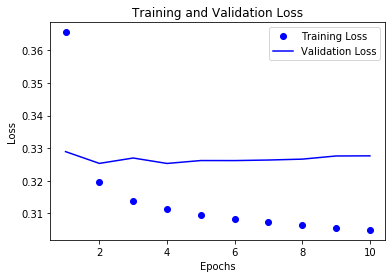

In [110]:
history_dict = history.history
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']

epochs = range(1, len(loss_values) + 1)

plt.plot(epochs, loss_values, 'bo', label = 'Training Loss')
plt.plot(epochs, val_loss_values, 'b', label = 'Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

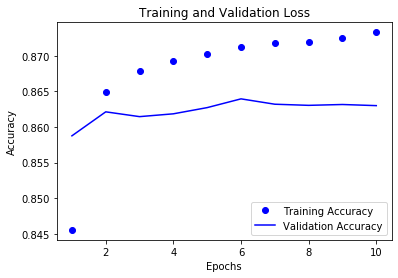

In [111]:
history_dict = history.history
accuracy_values = history_dict['accuracy']
val_accuracy_values = history_dict['val_accuracy']

epochs = range(1, len(accuracy_values) + 1)

plt.plot(epochs, accuracy_values, 'bo', label = 'Training Accuracy')
plt.plot(epochs, val_accuracy_values, 'b', label = 'Validation Accuracy')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

In [112]:
model.evaluate(X_test , y_test)

42029/42029 [==============================] - 3s 60us/step


[0.3270096271335277, 0.8643555641174316]

## Predicting New Data

In [113]:
teste = data_reviewsEN.sample(frac=0.1, random_state=25)

In [114]:
vectors = vectorizer.transform(teste['clean_reviews'])

In [115]:
pred = model.predict(vectors)

In [116]:
teste['Predicted'] = np.around(pred, 2)

In [117]:
teste.sample(n=20)

,date_posted,funny,helpful,hour_played,is_early_access_review,recommendation,review,title,length_review,clean_reviews,language,Predicted
108647,2017-06-17,0,0,1014,False,Not Recommended,Did you think GTA 4 is the worst game of whole...,Grand Theft Auto V,1055,think gta worst game whole series gta much wor...,en,0.02
368567,2018-06-24,0,0,13,False,Not Recommended,Product received for free. dont try itit got b...,Rust,88,product received free dont try itit got blue s...,en,0.16
158144,2015-04-30,3,2,871,False,Recommended,I Sold all CS GO skins to buy this games.And y...,Grand Theft Auto V,79,sold c go skin buy game know worth game simply...,en,0.90
7048,2018-09-18,0,0,388,False,Not Recommended,New killer is pretty much a bag of But you can...,Dead by Daylight,55,new killer pretty much bag throw rock survivor...,en,0.84
86333,2015-12-08,0,0,527,False,Recommended,One of the best games i played!!Pro Unbelievab...,Rocket League®,240,one best game played pro unbelievable fun frie...,en,0.99
208173,2018-04-11,0,0,67,False,Recommended,Let's just say the game ain't easy. It took me...,PLAYERUNKNOWN'S BATTLEGROUNDS,163,let say game easy took game exact get win game...,en,0.91
236871,2017-10-05,0,0,15,True,Not Recommended,Product received for free. worst game ever,PLAYERUNKNOWN'S BATTLEGROUNDS,37,product received free worst game ever,en,0.03
404375,2018-06-07,0,0,2265,False,Recommended,If you want a new full time job here is the pe...,Rust,35,want new full time job perfect game,en,0.95
307778,2017-12-22,0,0,37,False,Recommended,Its ok there is alot of glitches and things th...,PLAYERUNKNOWN'S BATTLEGROUNDS,56,ok alot glitch thing make mad friend like game...,en,0.92
394857,2016-08-27,0,0,1668,True,Not Recommended,THIS GAME SUCKS UNLESS YOU JOIN A LARGE CLAN W...,Rust,199,game suck unless join large clan hacker hacker...,en,0.11
